<a href="https://colab.research.google.com/github/pedrozamboni/bank_cds/blob/main/1_day_forecast_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### import important stuff
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Bidirectional, LSTM, Dropout, Dense,Input, Conv1D
from keras.models import Model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import scipy.stats

In [2]:
### open dataframe
df = pd.read_excel("/content/drive/MyDrive/cabra/I am sharing 'Data_Table' with you").dropna().reset_index(drop=True)
### convert column Time from objetct to TimeStamp
df['ts'] = pd.to_datetime(df.Time, format = "%d.%m.%Y")

In [3]:
### func to create the datast from model training
def create_dataset(X, y, time_steps=1):

    Xs, ys = [], []

    for i in range(len(X) - time_steps):

        v = X.iloc[i:(i + time_steps)].values

        Xs.append(v)

        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)

### compiler
def compile_and_fit(model,x_train,y_train,x_val,y_val, MAX_EPOCHS,lstm_batch_size,learning_rate):

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(x_train, y_train ,epochs=MAX_EPOCHS,
                    batch_size=lstm_batch_size,
                    validation_data=(x_val,y_val), shuffle=True
                    )
  return history

### lstm model
lstm_model = tf.keras.models.Sequential([
      # Shape [batch, time, features] => [batch, time, lstm_units]
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
      # Shape => [batch, time, features]
      tf.keras.layers.Dropout(rate=0.3),
      tf.keras.layers.Dense(units=1, kernel_initializer=tf.initializers.zeros())
  ])

### conv_lstm_model
conv_model = tf.keras.models.Sequential([
      # Shape [batch, time, features] => [batch, time, lstm_units]
      tf.keras.layers.Conv1D(filters = 128,
                              kernel_size=8,
                              strides=1,
                              activation='relu',
                             padding='same'),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
      tf.keras.layers.Dropout(rate=0.3),
      tf.keras.layers.Dense(units=1, kernel_initializer=tf.initializers.zeros())
  ])

def get_metrics (y_true,y_pred):
    metrics = np.zeros(6)
    metrics[0] = mean_absolute_percentage_error(y_true, y_pred)
    metrics[1] =  mean_absolute_error(y_true, y_pred)
    metrics[2] = mean_squared_error(y_true, y_pred)
    metrics[3] = mean_squared_error(y_true, y_pred, squared=False)
    metrics[4] = r2_score(y_true, y_pred)
    metrics[5] =  scipy.stats.spearmanr(y_true, y_pred)[0]
    return pd.DataFrame(metrics.reshape(1,6),columns = ['mape','mae','mse','rmse','r2',
                                                       'spearman'])
    

In [4]:
df['doy']=df.ts.apply(lambda x: x.day_of_year)
df = df.drop(["Time","ts"], axis=1)
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [5]:
x_train, y_train = create_dataset(train_df.drop('Banks CDS_avg',axis=1) ,train_df['Banks CDS_avg'], 7)
x_val, y_val= create_dataset(val_df.drop('Banks CDS_avg',axis=1) ,val_df['Banks CDS_avg'], 7)
x_test, y_test = create_dataset(test_df.drop('Banks CDS_avg',axis=1) ,test_df['Banks CDS_avg'], 7)

In [6]:
lstm_history = compile_and_fit(lstm_model,x_train,y_train,x_val,y_val, 200,1028,0.01)

Epoch 1/200
3/3 [==============================] - 19s 819ms/step - loss: 0.9657 - root_mean_squared_error: 0.9827 - val_loss: 0.7735 - val_root_mean_squared_error: 0.8795
Epoch 2/200
3/3 [==============================] - 0s 34ms/step - loss: 0.7272 - root_mean_squared_error: 0.8527 - val_loss: 0.4228 - val_root_mean_squared_error: 0.6502
Epoch 3/200
3/3 [==============================] - 0s 34ms/step - loss: 0.4076 - root_mean_squared_error: 0.6385 - val_loss: 0.1445 - val_root_mean_squared_error: 0.3802
Epoch 4/200
3/3 [==============================] - 0s 35ms/step - loss: 0.1746 - root_mean_squared_error: 0.4179 - val_loss: 0.0229 - val_root_mean_squared_error: 0.1512
Epoch 5/200
3/3 [==============================] - 0s 40ms/step - loss: 0.1667 - root_mean_squared_error: 0.4083 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1566
Epoch 6/200
3/3 [==============================] - 0s 45ms/step - loss: 0.1663 - root_mean_squared_error: 0.4078 - val_loss: 0.0379 - val_root_mean_

In [7]:
conv_history = compile_and_fit(conv_model,x_train,y_train,x_val,y_val, 200,1028,0.01)

Epoch 1/200
3/3 [==============================] - 6s 419ms/step - loss: 0.9823 - root_mean_squared_error: 0.9911 - val_loss: 0.8300 - val_root_mean_squared_error: 0.9110
Epoch 2/200
3/3 [==============================] - 0s 25ms/step - loss: 0.7426 - root_mean_squared_error: 0.8617 - val_loss: 0.3101 - val_root_mean_squared_error: 0.5568
Epoch 3/200
3/3 [==============================] - 0s 24ms/step - loss: 0.3164 - root_mean_squared_error: 0.5625 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1033
Epoch 4/200
3/3 [==============================] - 0s 28ms/step - loss: 0.2140 - root_mean_squared_error: 0.4626 - val_loss: 0.0552 - val_root_mean_squared_error: 0.2349
Epoch 5/200
3/3 [==============================] - 0s 25ms/step - loss: 0.2065 - root_mean_squared_error: 0.4544 - val_loss: 0.0407 - val_root_mean_squared_error: 0.2018
Epoch 6/200
3/3 [==============================] - 0s 27ms/step - loss: 0.0948 - root_mean_squared_error: 0.3079 - val_loss: 0.1073 - val_root_mean_s

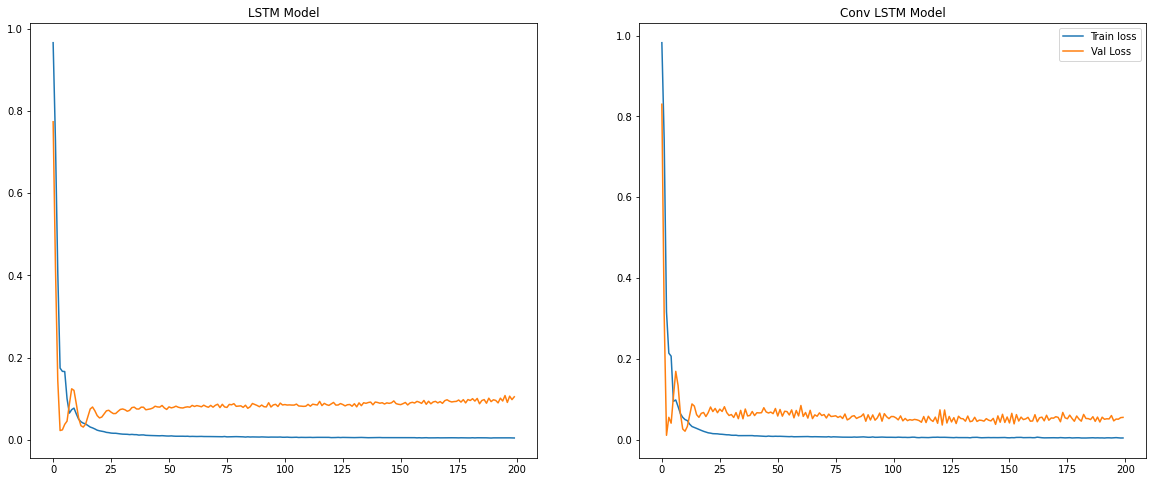

In [9]:
fig, ax = plt.subplots(1,2, figsize = (20,8))
ax[0].plot(lstm_history.history['loss'], label = "Train loss")
ax[0].plot(lstm_history.history['val_loss'] , label = "Val Loss")
ax[0].set_title("LSTM Model")

ax[1].plot(conv_history.history['loss'], label = "Train loss")
ax[1].plot(conv_history.history['val_loss'] , label = "Val Loss")
ax[1].set_title("Conv LSTM Model")
plt.legend()

In [10]:
### Models evalulte
print("LSTM Model test Loss: ",lstm_model.evaluate(x_test,y_test, verbose = 0)[0])
print("LSTM Model test RootMeanSquaredError: ",lstm_model.evaluate(x_test,y_test, verbose = 0)[1])
print("Conv LSTM Model test Loss: ",conv_model.evaluate(x_test,y_test, verbose = 0)[0])
print("Conv LSTM Model test RootMeanSquaredError: ",conv_model.evaluate(x_test,y_test, verbose = 0)[1])

LSTM Model test Loss:  0.023991651833057404
LSTM Model test RootMeanSquaredError:  0.15489238500595093
Conv LSTM Model test Loss:  0.005863369908183813
Conv LSTM Model test RootMeanSquaredError:  0.07657264173030853


In [15]:
pd.concat([
    get_metrics(y_test,lstm_model.predict(x_test)),
    get_metrics(y_test,conv_model.predict(x_test))
    ] , axis = 0).reset_index(drop=True).rename(index={0:'LSTM',1:"Conv LSTM"})

11/11 [==============================] - 0s 7ms/step


,mape,mae,mse,rmse,r2,spearman
LSTM,0.179952,0.142002,0.023992,0.154892,0.369905,0.929232
Conv LSTM,0.075904,0.062067,0.005863,0.076573,0.846010,0.930268


In [17]:
y_test_inv=(y_test*train_std['Banks CDS_avg'])+train_mean['Banks CDS_avg']


lstm_test=lstm_model.predict(x_test)
lstm_test_inv=(lstm_test*train_std['Banks CDS_avg'])+train_mean['Banks CDS_avg']

conv_test=conv_model.predict(x_test)
conv_test_inv=(conv_test*train_std['Banks CDS_avg'])+train_mean['Banks CDS_avg']

11/11 [==============================] - 0s 4ms/step


Text(0.5, 1.0, 'Conv LSTM Model test set')

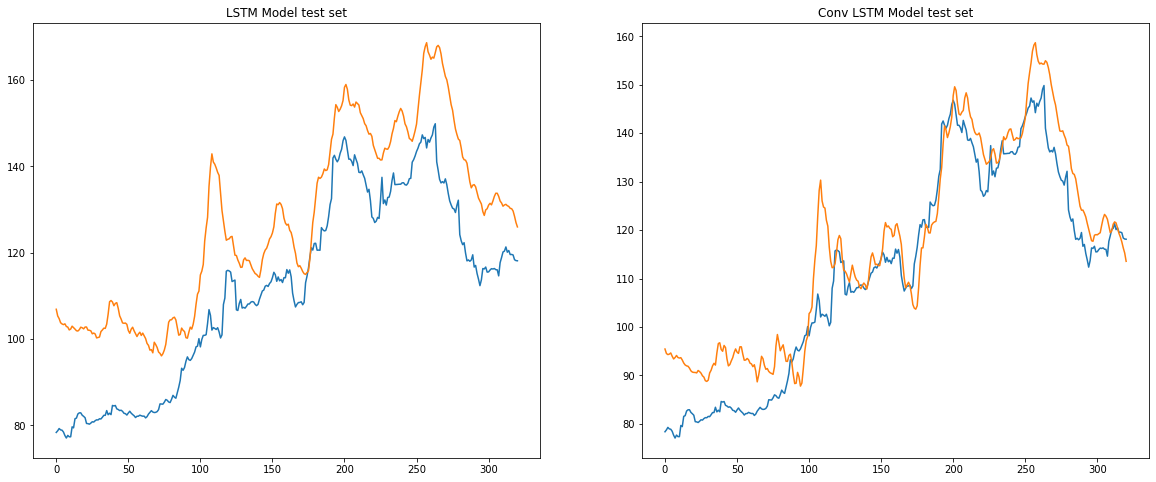

In [19]:
fig, ax = plt.subplots(1,2, figsize = (20,8))
ax[0].plot(y_test_inv, label = "True")
ax[0].plot(lstm_test_inv, label = "Pred")
ax[0].set_title("LSTM Model test set")

ax[1].plot(y_test_inv, label = "True")
ax[1].plot(conv_test_inv, label = "Pred")
ax[1].set_title("Conv LSTM Model test set")